In [72]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [73]:
import numpy as np

In [74]:
! pip install "numpy>=1.16.5,<1.23.0"

^C


In [75]:
all_tweets= pd.read_csv("musktweets.csv", index_col = [0])

In [98]:
all_tweets.head()

,MESSAGE,date
0,"Please ignore prior tweets, as that was someon...",2010-06-04 18:31:57+00:00
1,Went to Iceland on Sat to ride bumper cars on ...,2011-12-01 09:55:11+00:00
2,I made the volume on the Model S http://ow.ly/...,2011-12-01 10:29:04+00:00
3,"Great Voltaire quote, arguably better than Twa...",2011-12-03 08:20:28+00:00
4,That was a total non sequitur btw\n26\n14\n50,2011-12-03 08:22:07+00:00


In [99]:
# Filter the data using keywords
all_tweets['MESSAGE'].fillna('', inplace=True)
keywords = ['Bitcoin', 'BTC', 'Bit coin', 'bitcoin']

filtered_dataset = all_tweets[all_tweets['MESSAGE'].str.contains('|'.join(keywords), case=False)]


In [78]:
# Upload Bitcoin dataset with historical data
btc_dataset = pd.read_csv("BTC-Hourly.csv")


In [79]:
btc_dataset.drop('high', axis=1, inplace=True)
btc_dataset.drop('low', axis=1, inplace=True)
btc_dataset.drop('symbol', axis=1, inplace=True)
btc_dataset.drop('Volume BTC', axis=1, inplace=True)
btc_dataset.drop('Volume USD', axis=1, inplace=True)

In [110]:
#filtered_dataset.loc[:, 'date'] = filtered_dataset['date'].dt.floor('H')
filtered_dataset['date'] = pd.to_datetime(filtered_dataset['date'], utc=True)
btc_dataset['date'] = pd.to_datetime(btc_dataset['date'], utc=True)

In [103]:
filtered_dataset.loc[:, 'date'] = filtered_dataset['date'].dt.floor('H')

In [111]:
btc_dataset.dtypes

unix                   int64
date     datetime64[ns, UTC]
open                 float64
close                float64
dtype: object

In [105]:
filtered_dataset = filtered_dataset.reset_index(drop = True)

In [112]:
# Sort the btc_dataset by date
btc_dataset = btc_dataset.sort_values('date')
filtered_dataset.loc[:, 'tweeted'] = filtered_dataset['date'].apply(
    lambda x: 1 if any((x - pd.Timedelta(hours=1) < btc_dataset['date']) & (btc_dataset['date'] <= x)) else 0
)

# Calculate the mean before and after each tweet
tweet_impact = []
for i, row in filtered_dataset.iterrows():
    if row['tweeted'] == 1:
        tweet_time = row['date']
        before_tweet = btc_dataset[btc_dataset['date'] < tweet_time].tail(12)
        after_tweet = btc_dataset[btc_dataset['date'] > tweet_time].head(12)
        mean_before_tweet = before_tweet['open'].mean()
        mean_after_tweet = after_tweet['close'].mean()
        tweet_impact.append((tweet_time, mean_before_tweet, mean_after_tweet))  # Include tweet_time in the tuple

for impact in tweet_impact:
    print(f"Tweet Date: {impact[0]}, Mean before tweet: {impact[1]}, Mean after tweet: {impact[2]}")


Tweet Date: 2018-05-24 00:00:00+00:00, Mean before tweet: 7690.420833333334, Mean after tweet: 7538.780833333333
Tweet Date: 2018-10-22 23:00:00+00:00, Mean before tweet: 6399.050833333334, Mean after tweet: 6397.48
Tweet Date: 2019-02-21 10:00:00+00:00, Mean before tweet: 3927.7033333333334, Mean after tweet: 3893.2258333333334
Tweet Date: 2019-02-21 10:00:00+00:00, Mean before tweet: 3927.7033333333334, Mean after tweet: 3893.2258333333334
Tweet Date: 2019-02-21 10:00:00+00:00, Mean before tweet: 3927.7033333333334, Mean after tweet: 3893.2258333333334
Tweet Date: 2019-04-02 20:00:00+00:00, Mean before tweet: 4755.770833333333, Mean after tweet: 4946.2525
Tweet Date: 2019-04-14 22:00:00+00:00, Mean before tweet: 5080.473333333333, Mean after tweet: 5161.690833333334
Tweet Date: 2020-01-10 06:00:00+00:00, Mean before tweet: 7810.149166666667, Mean after tweet: 7876.296666666666
Tweet Date: 2020-01-10 06:00:00+00:00, Mean before tweet: 7810.149166666667, Mean after tweet: 7876.29666666

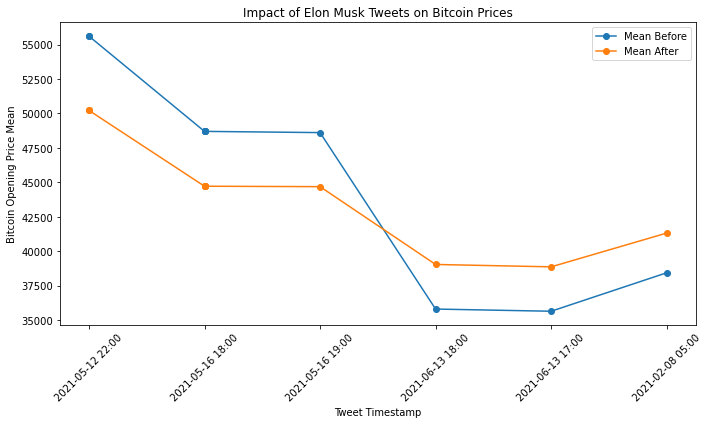

In [113]:
# Sort the tweet impact by the difference in means
tweet_impact.sort(key=lambda x: abs(x[2] - x[1]), reverse=True)

# Get the 15 most important tweets
top_tweets = tweet_impact[:10]

# Prepare data for visualization
dates = [tweet[0].strftime("%Y-%m-%d %H:%M") for tweet in top_tweets]
mean_before = [tweet[1] for tweet in top_tweets]
mean_after = [tweet[2] for tweet in top_tweets]

# Create the line plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(dates, mean_before, marker='o', label='Mean Before')
ax.plot(dates, mean_after, marker='o', label='Mean After')
ax.set_xlabel('Tweet Timestamp')
ax.set_ylabel('Bitcoin Opening Price Mean')
ax.set_title('Impact of Elon Musk Tweets on Bitcoin Prices')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()